Эксперименты по решению дифференциальных уравнений с периодическими г.у. при помощи PINN

Подход из статьи ( Sifan Wang, Shyam Sankaran ) Respecting causality is all you need for training physics-informed neural networks

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class PeriodicLayer(nn.Module):
    """
    Periodic layer recreating from the article:
    ( Sifan Wang, Shyam Sankaran ) Respecting causality is all you need for training physics-informed neural networks
    """
    def __init__(self, m: int, omega: float):
        super().__init__()
        self.m = m
        self.omega = omega

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (n, 1)
        Возвращает: ((2*m + 1)*n, 1)
        """
        n = x.shape[0]
        features = [torch.ones_like(x)]
        for k in range(1, self.m + 1):
            features.append(torch.sin(k * self.omega * x))
            features.append(torch.cos(k * self.omega * x))
        #out = torch.cat(features, dim=1)   # (n, 2*m + 1)
        #out = out.reshape(-1, 1)           # ((2*m + 1)*n, 1)
        return torch.cat(features, dim=1)

Задание сложной периодической функции с периодом 2

Text(0, 0.5, 'u')

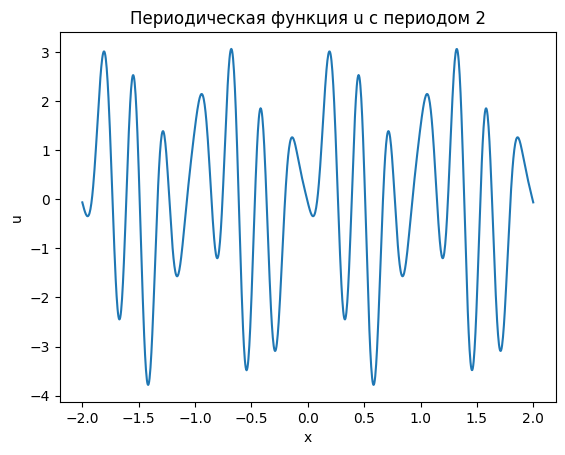

In [4]:
pi = torch.pi
u_exact = lambda x: torch.sin(2*pi*x + 0.25*pi) + torch.cos(9*pi*x -0.1*pi) - 2.0*torch.sin(7.0*pi*x + 0.33*pi)

x = torch.linspace(-2, 2, 1000)
plt.plot(x, u_exact(x))
plt.title("Периодическая функция u с периодом 2")
plt.xlabel("x")
plt.ylabel("u")

In [ ]:
# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЯ И ЕГО ЗАПУСК ---
domain = [0, 2]
n = 100
m = 3
n_epochs = 1000

device = 'cuda'
torch.manual_seed(2008)
model = nn.Sequential(
    PeriodicLayer(m, torch.pi), nn.Tanh(), 
    nn.Linear(2*m + 1, 128), nn.Tanh(), 
    nn.Linear(128,128), nn.Tanh(), 
    nn.Linear(128, 1)
).to(device=device)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
loss = torch.zeros(n_epochs)

pbar = tqdm(range(1, n_epochs + 1))
for k in pbar:
    x = (domain[1] - domain[0]) * torch.rand(n, 1, device=device) + domain[0]
    u = model(x)
    optimizer.zero_grad()
    tmp = torch.mean( (u - u_exact(x))**2 )
    tmp.backward()
    optimizer.step()
    loss[k-1] = tmp.detach().cpu()
    if k == 1 or k % 100 == 0:
        pbar.set_postfix(loss=f"{loss[k-1]:10.4e}")

100%|██████████| 1000/1000 [00:02<00:00, 367.15it/s, loss=6.4786e-04]


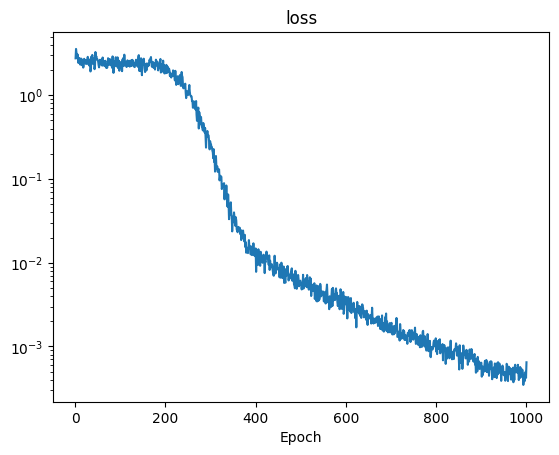

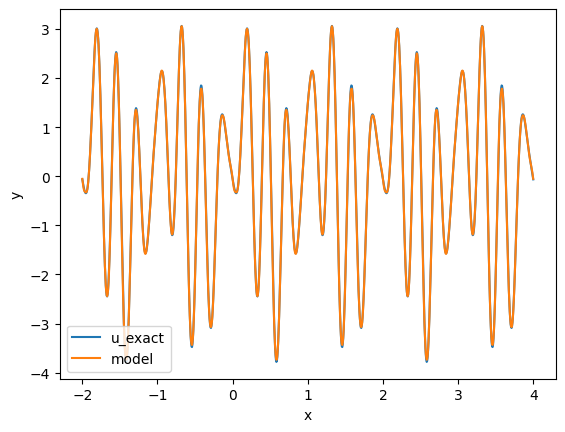

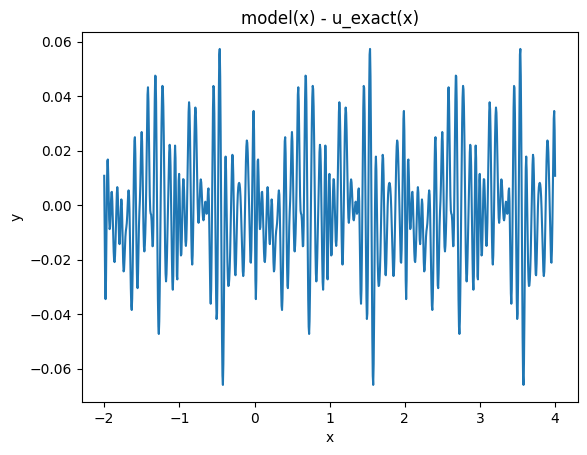

In [12]:
plt.semilogy(range(1, n_epochs + 1), loss.detach().cpu())
plt.xlabel("Epoch")
plt.title("loss")
plt.show()

model = model.to("cpu")
x = torch.linspace(*[-2, 4], 1000).reshape(-1, 1)

plt.plot(x, u_exact(x), label="u_exact")
plt.plot(x, model(x).detach().cpu(), label="model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.plot(x, model(x).detach().cpu() - u_exact(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("model(x) - u_exact(x)")
plt.show()

Модель обучалась на интервале [0, 2], но успешно аппроксимирует исходную функцию и за его пределами